In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
plt.style.use(["science","no-latex", "/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle"])
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/")

# Load Dataset

In [2]:
from LoadMultiFiles import LoadOneFileUproot, LoadMultiROOTFiles
from FunctionFor_dE_dx import GetNPE, GetDirForNoOpticalAnalyze
from GetPhysicsProperty import NameToPDGID
from copy import copy
from HistTools import GetBinCenter
filter_leaves = ['xyz_center',  'step_Edep', 'step_Equench']
template_root_path = "/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/root_calib/{}_10cm_*.root"
df_dEdx = pd.DataFrame()
particle = "H_2"

dir_PMT_near = LoadMultiROOTFiles(template_root_path.format(particle), name_branch="PMT_log",  list_branch_filter=filter_leaves)
dir_PMT_calib_3inches = LoadMultiROOTFiles(template_root_path.format(particle), name_branch="PMT_3inches_calib_distance2PE_log",
                                           list_branch_filter=filter_leaves)
dir_PMT_calib_1inches = LoadMultiROOTFiles(template_root_path.format(particle), name_branch="PMT_1inches_calib_distance2PE_log",
                                           list_branch_filter=filter_leaves)
dir_geninfo = LoadMultiROOTFiles(template_root_path.format(particle), name_branch="genInfo",  list_branch_filter=filter_leaves)
dir_PMT_far = LoadMultiROOTFiles(template_root_path.format(particle), name_branch="PMT_log_R7600",  list_branch_filter=filter_leaves)

/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/LoadMultiFiles.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dir_events[key] = np.array(dir_events[key])


# PMT Distance to PE Map
## Get Responding PEs

In [3]:
v_PE_1 = GetNPE(dir_PMT=dir_PMT_near,chamberID=0, mean=False)
v_PE_2 = GetNPE(dir_PMT=dir_PMT_near,chamberID=1, mean=False)
v_PE_sum = v_PE_1+v_PE_2
d_PMT = np.abs( np.mean( list( set(dir_PMT_near["step_x"][0][dir_PMT_near["step_chamberID"][0]==0]) ) ) )

dict_d2PE_3inches_calib = {}
dict_d2PE_3inches_calib_median = {}

for chamberID in set(np.concatenate(dir_PMT_calib_3inches["step_chamberID"])):
    d_PMT_tmp = -np.mean( list( set(dir_PMT_calib_3inches["step_z"][0][dir_PMT_calib_3inches["step_chamberID"][0]==chamberID]) ) )
    dict_d2PE_3inches_calib[d_PMT_tmp] = GetNPE(dir_PMT=dir_PMT_calib_3inches,chamberID=chamberID, mean=False)
    dict_d2PE_3inches_calib_median[d_PMT_tmp] = np.median(dict_d2PE_3inches_calib[d_PMT_tmp])

dict_d2PE_1inches_calib = {}
dict_d2PE_1inches_calib_median = {}
for chamberID in set(np.concatenate(dir_PMT_calib_1inches["step_chamberID"])):
    d_PMT_tmp = -np.mean( list( set(dir_PMT_calib_1inches["step_z"][0][dir_PMT_calib_1inches["step_chamberID"][0]==chamberID]) ) )
    dict_d2PE_1inches_calib[d_PMT_tmp] = GetNPE(dir_PMT=dir_PMT_calib_1inches,chamberID=chamberID, mean=False)
    dict_d2PE_1inches_calib_median[d_PMT_tmp] = np.median(dict_d2PE_1inches_calib[d_PMT_tmp])


/cvmfs/juno.ihep.ac.cn/sw/anaconda/Anaconda3-2020.11-Linux-x86_64/envs/root624/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/juno.ihep.ac.cn/sw/anaconda/Anaconda3-2020.11-Linux-x86_64/envs/root624/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## PMT Calibration Curves

Text(0.5, 1.0, 'H2 Beam')

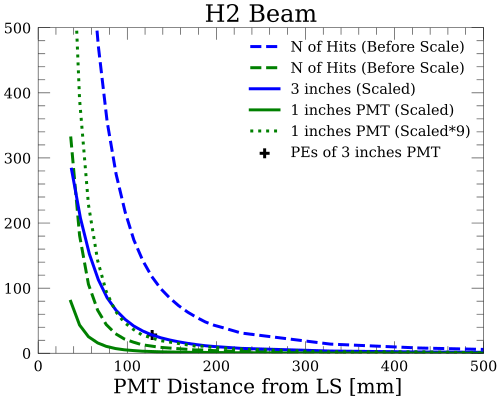

In [4]:
from scipy.interpolate import interp1d
plt.plot(dict_d2PE_3inches_calib_median.keys(), dict_d2PE_3inches_calib_median.values(),
         label="N of Hits (Before Scale)", ls="--", color="blue")
plt.plot(dict_d2PE_1inches_calib_median.keys(), dict_d2PE_1inches_calib_median.values(),
         label="N of Hits (Before Scale)", ls="--", color="green")

# Scale PEs curve
f = interp1d(list(dict_d2PE_3inches_calib_median.keys()), list(dict_d2PE_3inches_calib_median.values()))
factor_scale = np.median(v_PE_1)/f(d_PMT)
plt.plot(dict_d2PE_3inches_calib_median.keys(), np.array(list(dict_d2PE_3inches_calib_median.values()))*factor_scale,
         label="3 inches (Scaled)", color="blue")
plt.plot(dict_d2PE_1inches_calib_median.keys(), np.array(list(dict_d2PE_1inches_calib_median.values()))*factor_scale,
         label="1 inches PMT (Scaled)", color="green")
plt.plot(dict_d2PE_1inches_calib_median.keys(), np.array(list(dict_d2PE_1inches_calib_median.values()))*factor_scale*9,
         label="1 inches PMT (Scaled*9)", color="green", ls=":")

plt.scatter(d_PMT, np.median(v_PE_1), color="black", marker="+", label="PEs of 3 inches PMT")
plt.xlim(0,500)
plt.ylim(0, 500)
plt.xlabel("PMT Distance from LS [mm] ")

# plt.semilogy()
plt.legend()
plt.title("H2 Beam")

# Beam Span Impact (Photon Wavelength)
## Get Kinetic Energy

In [5]:
from matplotlib.colors import LogNorm
from PlotTools import AutoGetColorWithALotOfLine
v_x_beam_alignEkArr = []
v_z_beam_alignEkArr = []
v2d_Ek_oneChamber = []
chamberID = 1
for v_chamberID, v_Ek, x_beam,z_beam in zip(dir_PMT_calib_1inches["step_chamberID"],
                                     dir_PMT_calib_1inches["step_KineticE"],
                                     dir_geninfo["XYZ"][:, 0],
                                     dir_geninfo["XYZ"][:, 2]):
    v_Ek_oneChamber = v_Ek[v_chamberID==chamberID]
    v_x_beam_alignEkArr += [x_beam]*len(v_Ek_oneChamber)
    v_z_beam_alignEkArr += [z_beam]*len(v_Ek_oneChamber)
    v2d_Ek_oneChamber.append(v_Ek_oneChamber)

print("Length Check:\t",len(v_x_beam_alignEkArr), len(np.concatenate(v2d_Ek_oneChamber)))
v_z_beam_alignEkArr = np.array(v_z_beam_alignEkArr)
v_x_beam_alignEkArr = np.array(v_x_beam_alignEkArr)
v2d_Ek_oneChamber = np.array(v2d_Ek_oneChamber)


Length Check:	 3754896 3754896


/tmp/ipykernel_26872/2314455451.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  v2d_Ek_oneChamber = np.array(v2d_Ek_oneChamber)


## Get Photon Ek VS. Beam X Distribution

Text(0.5, 1.0, '-5 mm < BeamZ < 5 mm')

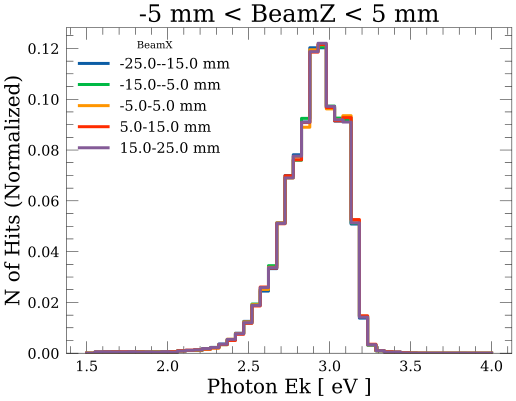

In [6]:
beamZ_lim = (-5, 5) # mm
index_z = (v_z_beam_alignEkArr<beamZ_lim[1]) & (v_z_beam_alignEkArr>beamZ_lim[0])
bins_beamX = np.linspace(-25, 25, 6)
for i, (lower_beamX, upper_beamX) in enumerate( zip(bins_beamX[:-1], bins_beamX[1:]) ):
    index_x = (v_x_beam_alignEkArr<upper_beamX) & (v_x_beam_alignEkArr>lower_beamX)
    color = AutoGetColorWithALotOfLine(i)
    sns.histplot(np.concatenate(v2d_Ek_oneChamber)[index_z&index_x]*1e6, bins=np.linspace(1.5,4,50),
                fill=False, element="step", label=f"{lower_beamX:.1f}-{upper_beamX:.1f} mm", stat="probability",
                color=color)
plt.legend(title="BeamX")
plt.xlabel("Photon Ek [ eV ]")
plt.ylabel("N of Hits (Normalized)")
plt.title(f"{beamZ_lim[0]} mm < BeamZ < {beamZ_lim[1]} mm")
